In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from clearml import Task

from sklearn import linear_model
from sklearn import preprocessing

from amplify.DataGeneration import DataGenerator

In [ ]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="power-ss-notebook")


In [6]:
# DataGenerator - ClearML
data_generator = DataGenerator()
xy_data = data_generator.load_data()
xy_data.head()

Info: Successfully loaded building data!


/Users/samsipe/Developer/amplify-microgrid-ai/.venv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: overflow encountered in exp
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime
/Users/samsipe/Developer/amplify-microgrid-ai/.venv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: invalid value encountered in multiply
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime


Info: Successfully loaded weather data!


,temp,pressure,humidity,clouds_all,irradiance,solar,usage
2021-10-19 04:00:00+00:00,10.07,1017.0,66.0,20.0,0.0,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,1017.0,70.0,20.0,0.0,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,1017.0,71.0,20.0,0.0,1.0,12.7
2021-10-19 07:00:00+00:00,9.12,1017.0,72.0,20.0,0.0,1.0,17.2
2021-10-19 08:00:00+00:00,9.12,1017.0,73.0,20.0,0.0,1.0,17.0


##Below this point needs to be adjustd for new data generation output into a single DF

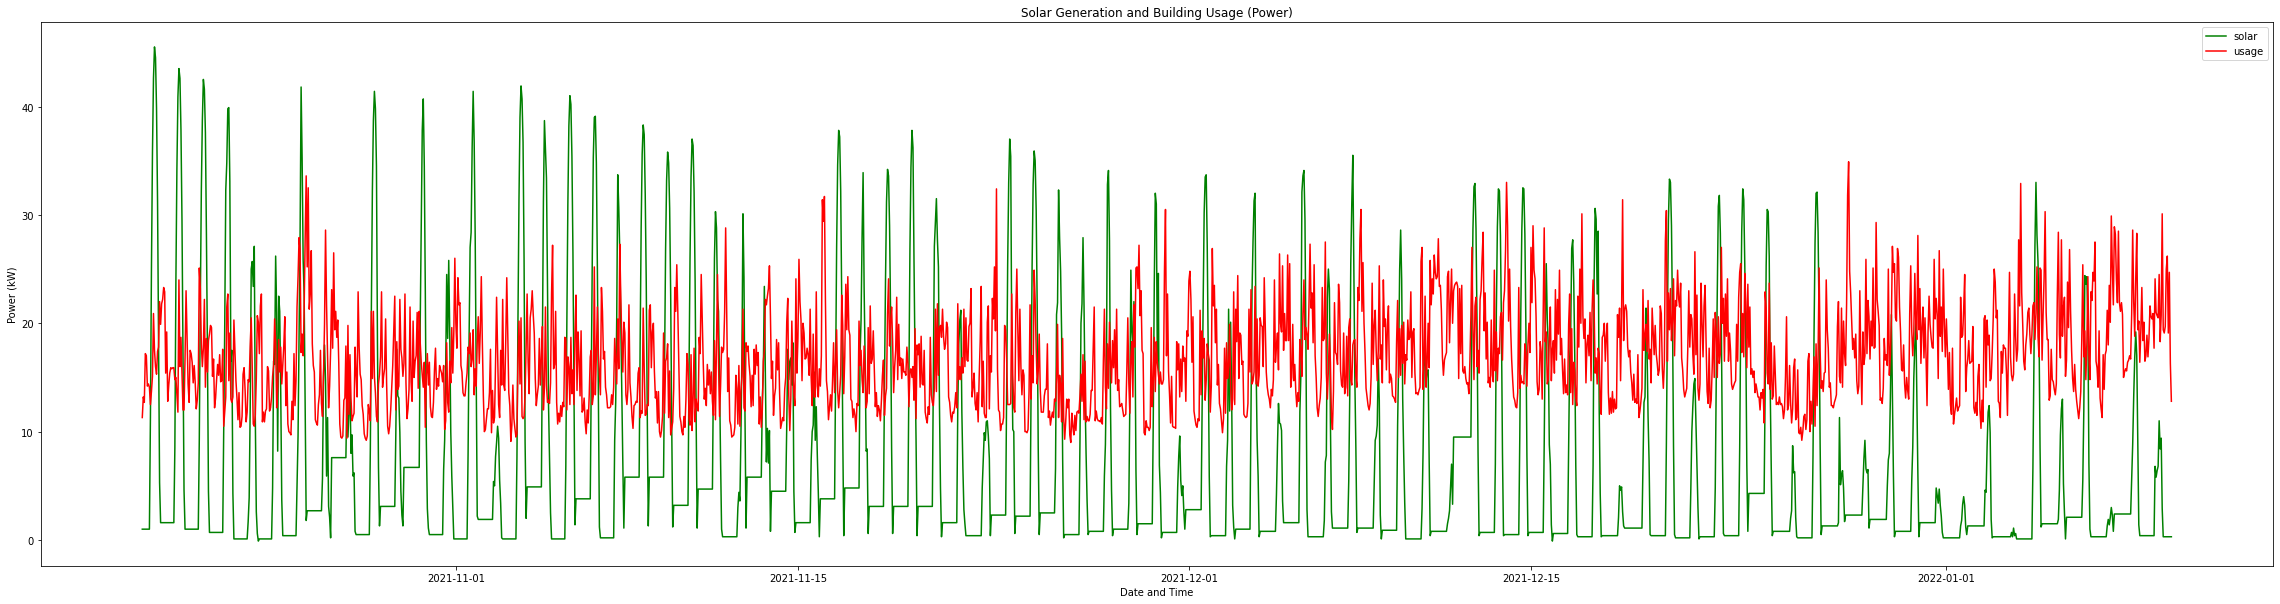

In [7]:
# Plot Power - Solar Gen vs Building Usage
fig, ax = plt.subplots(figsize=(40, 10))
plt.title("Solar Generation and Building Usage (Power)")

ax.plot(xy_data.solar, color="g")
ax.plot(xy_data.usage, color="r")

ax.set_xlabel("Date and Time")
ax.set_ylabel("Power (kW)")
plt.legend(xy_data.columns[5:7])
plt.show()


In [13]:
# Build class for EWM Linear Regression to compare scaled/non-scaled features
class Weather_EWM:
    def __init__(self, features, y, split_date, scaled=True):
        self.data = features
        self.y = y
        self.split_date = split_date
        self.scale = scaled

    # Reversed-Recombined EWMA for improved accuracy
    def ewm_calculator(self):

        # Create dataframe To collect data
        self.ewm_out = pd.DataFrame()

        # Calculate fwd and bwd EWMA
        self.ewm_out["fwd"] = self.y.ewm(span=24).mean()
        self.ewm_out["bwd"] = self.y[::-1].ewm(span=24).mean()

        # Reversed-Recombined EWMA
        self.ewm_out["combo"] = self.ewm_out.mean(axis=1)

        return self.ewm_out

    # Test/Train split and standardization of weather data
    def weather_prep(self):

        # Run ewma calculator
        self.ewm = self.ewm_calculator()

        # Test / Train split for Y based on chosen split_date
        self.ewm_train = self.ewm[self.ewm.index <= self.split_date]
        self.ewm_test = self.ewm[self.ewm.index > self.split_date]

        # Test/Train split for Weather data to match Y-data
        self.weather_train = self.data[: len(self.ewm_train)]
        self.weather_test = self.data[len(self.ewm_train) :]

        # Scale features in training set:
        if self.scale:
            self.weather_scaler = preprocessing.StandardScaler()
            self.weather_train = self.weather_scaler.fit_transform(self.weather_train)

        return self.weather_train, self.weather_test, self.ewm_train, self.ewm_test

    def weather_ewma(self):
        # Run train/test split based on date and scaling
        self.x_train, self.x_test, self.y_train, self.y_test = self.weather_prep()

        # On to the regression:
        self.lin_reg = linear_model.LinearRegression()
        self.lin_reg.fit(self.x_train, self.y_train.combo)

        self.ewm_solar_pred = self.lin_reg.predict(self.x_test)

        return self.ewm_solar_pred


/Users/samsipe/Developer/amplify-microgrid-ai/.venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


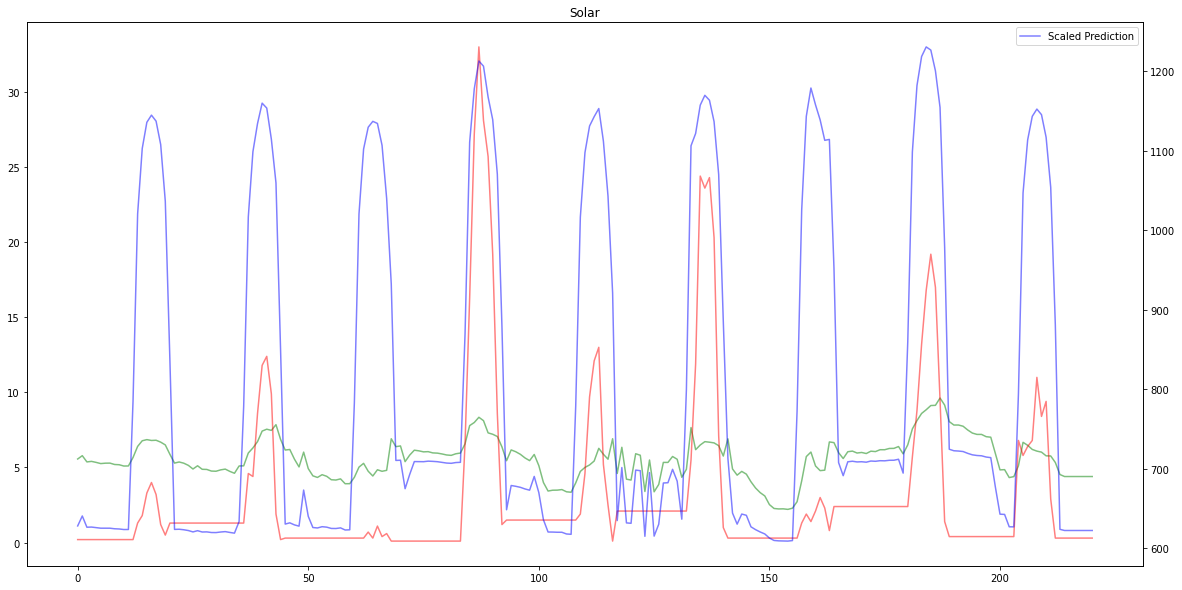

/Users/samsipe/Developer/amplify-microgrid-ai/.venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


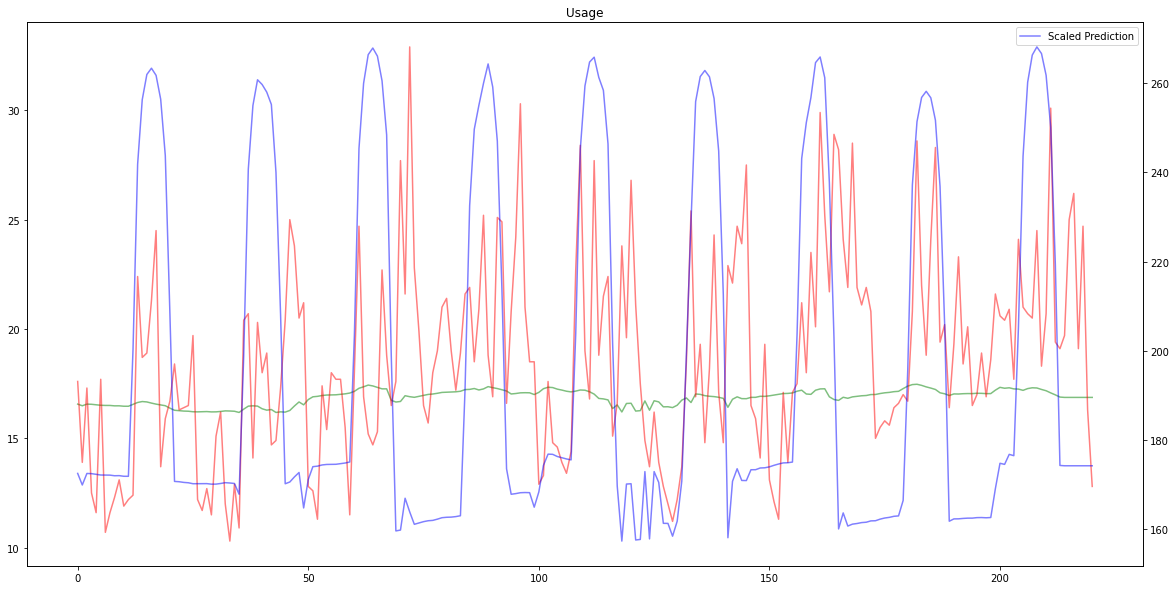

In [16]:
# Set split date for Linear Regression validation
split_date = pd.to_datetime("2022-01-01", utc=True)

# Set list of y-values we want to predict
X_vals = xy_data.drop(['solar','usage'], axis=1)
y_vals = {"Solar": xy_data.solar, "Usage": xy_data.usage}

# To run the usage and power regressions
for key in y_vals:
    # Create the separate instances for scaled/not scaled:
    WE_not_scaled = Weather_EWM(
        features=X_vals, y=y_vals[key], split_date=split_date, scaled=False
    )
    WE_scaled = Weather_EWM(features=X_vals, y=y_vals[key], split_date=split_date)

    # Run the linear regressions:
    lin_reg_scaled = WE_scaled.weather_ewma()
    lin_reg_not_scaled = WE_not_scaled.weather_ewma()

    # Plot the results
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax2 = ax1.twinx()

    # Set plot title
    title = key
    plt.title(label=title)

    # Plot prediction based on unscaled data
    ax1.plot(lin_reg_not_scaled, color="g", alpha=0.5, label="Predicted")

    # Plot prediction based on scaled data
    ax2.plot(lin_reg_scaled, color="b", alpha=0.5, label="Scaled Prediction")

    # Plot actual data
    ax1.plot(
        np.array(y_vals[key][-len(lin_reg_not_scaled) :]),
        color="r",
        alpha=0.5,
        label="Actual",
    )

    plt.xlabel("Hrs in future")
    plt.legend()
    plt.show()
